In [1]:
import os
import numpy as np
import h5py
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from pytorch_lightning import LightningModule
from sklearn.model_selection import train_test_split

In [2]:
# Path setup
model_path = "best_model_v14-MSE---epoch=22400-val_loss=0.00025909.ckpt"  
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'
save_dir = r'C:\Users\kiena\Python Project\Year4Project\dev\GarstecModel_V9' 
os.makedirs(save_dir, exist_ok=True)

In [3]:
# MSE loss

# Lightning Module
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        
        # Define MSE loss
        self.loss_fn = nn.MSELoss()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  # First layer
            nn.LeakyReLU(),
            nn.Linear(256, 256),  # Second layer
            nn.LeakyReLU(),
            nn.Linear(256, 128),  # Third layer
            nn.LeakyReLU(),
            nn.Linear(128, 128),  # Fourth layer
            nn.LeakyReLU(),
            nn.Linear(128, output_dim)  # Output layer
        )

    def forward(self, x):
        return self.model(x)


In [9]:
# Lightning Module
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        
        # Define loss weights
        self.loss_weights = torch.tensor([70, 0.1, 0.1, 0.5/3090, 0.01])
        
        # Store output scaler mean and std for inverse transformation
        self.register_buffer('output_mean', torch.zeros(output_dim))
        self.register_buffer('output_scale', torch.ones(output_dim))

        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  # First layer
            nn.LeakyReLU(),
            nn.Linear(256, 256),  # Second layer
            nn.LeakyReLU(),
            nn.Linear(256, 128),  # Third layer
            nn.LeakyReLU(),
            nn.Linear(128, 128),  # Fourth layer
            nn.LeakyReLU(),
            nn.Linear(128, output_dim)  # Output layer
        )
        

    def forward(self, x):
        return self.model(x)

In [4]:
def load_data():
    # 7 Inputs
    ages = []
    massini = []
    fehini = []
    alphamlt = []
    yini = []
    eta = []
    alphafe = []

    # 5 Outputs
    teff = []
    luminosity = []
    dnufit = []
    FeH = []
    numax = []

    # Open the hdf5 file (read-only mode)
    with h5py.File(garstec_data, 'r') as hdf:
        grid = hdf['grid']
        tracks = grid['tracks']

        # Get a list of track names and shuffle for random sampling
        track_names = list(tracks.keys())
        random.seed(1)
        random.shuffle(track_names)

        # Choose a subset of tracks to process (or not)
        selected_tracks = track_names[:]

        # Track which points belong to which tracks
        track_indices = []
        
        for track_name in selected_tracks:  # Iterate over the selected track names
            track = tracks[track_name]
            # Inputs
            ages.append(track['age'][:])
            massini.append(track['massini'][:])
            fehini.append(track['FeHini'][:])
            alphamlt.append(track['alphaMLT'][:])
            yini.append(track['yini'][:])
            eta.append(track['eta'][:])
            alphafe.append(track['alphaFe'][:])

            # Outputs
            teff.append(track['Teff'][:])
            luminosity.append(track['LPhot'][:])
            dnufit.append(track['dnufit'][:])
            FeH.append(track['FeH'][:])
            numax.append(track['numax'][:])
            
            # Add the track index for each point in this track
            track_indices.extend([len(track_indices)] * len(track['Teff'][:]))
    
    track_indices = np.array(track_indices)

    # Convert lists to numpy arrays and concatenate 
    # Define a small constant to avoid log10(0)
    epsilon = 1e-10

    # Features requiring log10 transformation - MODIFIED to exclude eta, massini, and alphamlt
    log10_vars_inputs = [ages, yini]  # Removed massini, alphamlt, and eta

    # Transform log10 variables
    log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]

    # Concatenate all inputs, including raw `massini`, `alphamlt`, `eta`, `fehini` and `alphafe`
    inputs = np.hstack(log10_transformed_inputs + [
        np.concatenate(massini).reshape(-1, 1),       # Raw massini
        np.concatenate(alphamlt).reshape(-1, 1),      # Raw alphamlt
        np.concatenate(eta).reshape(-1, 1),           # Raw eta
        np.concatenate(fehini).reshape(-1, 1),
        np.concatenate(alphafe).reshape(-1, 1)
    ])

    # Features requiring log10 transformation (strictly positive outputs)
    log10_vars_outputs = [teff, luminosity, dnufit, numax] 

    # Transform log10 variables
    log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]

    # Combine transformed log10 outputs with raw FeH
    outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1)])
    
    # Create a list of output parameter names for plotting
    output_names = ['log T_eff', 'log L', 'log dnu', 'log numax', 'FeH']
    
    return inputs, outputs, output_names, track_indices

In [5]:
# Calculate residuals with scaler

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Load data
inputs, outputs, output_names, track_indices = load_data()
    
# Split data with same random state as in training
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

   
# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
    
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
    
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)
    

# Load the trained model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
    
# Load model with map_location to handle device differences
model = GarstecNet.load_from_checkpoint(
    model_path, 
    input_dim=input_dim, 
    output_dim=output_dim,
    map_location=device
)
model.eval()  # Set to evaluation mode
model.to(device)  # Ensure model is on the correct device
    
# Make predictions on test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()  # Move predictions back to CPU before converting to numpy
    
# Inverse transform predictions and actual values to get original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)
    
# Calculate residuals
log_residuals = y_pred_original - y_test_original

# Convert predictions and test values from log to linear scale
# For the first 4 outputs (teff, luminosity, dnufit, numax) which were log-transformed
normal_pred = np.copy(y_pred_original)
normal_test = np.copy(y_test_original)

# Convert log outputs back to linear scale
for i in range(4):  # First 4 columns were log-transformed
    normal_pred[:, i] = 10**normal_pred[:, i]
    normal_test[:, i] = 10**normal_test[:, i]
# Note: FeH (index 4) was not log-transformed, so we leave it as is

# Calculate normal residuals
normal_residuals = normal_pred - normal_test


Using device: cuda


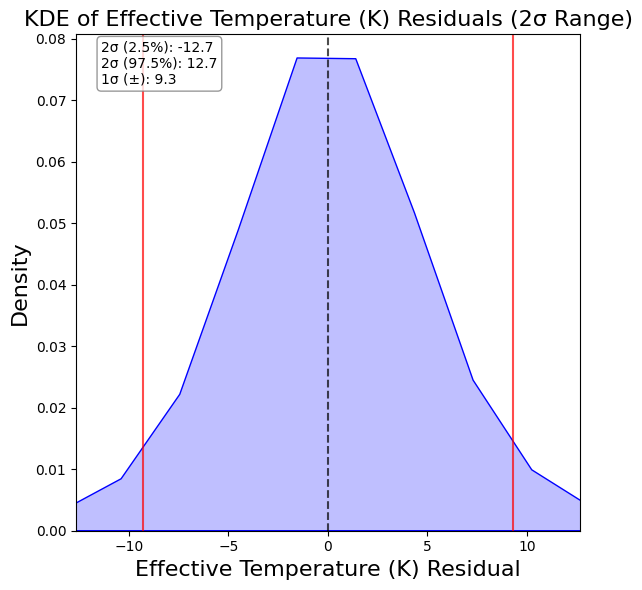

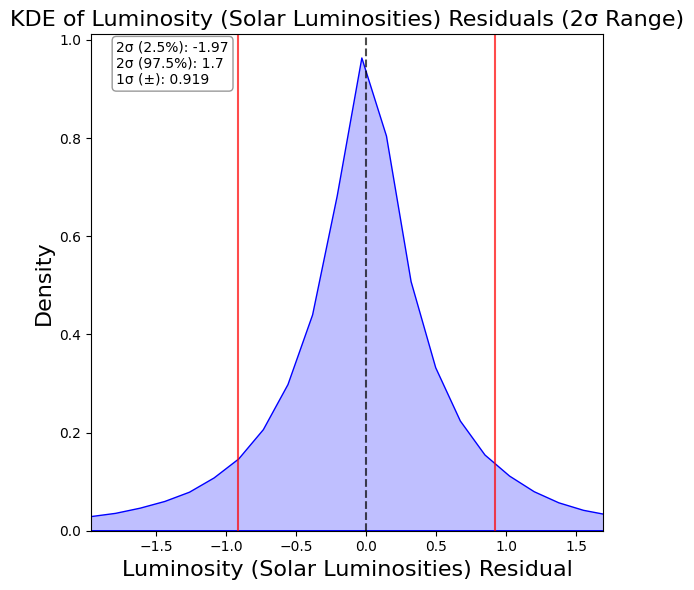

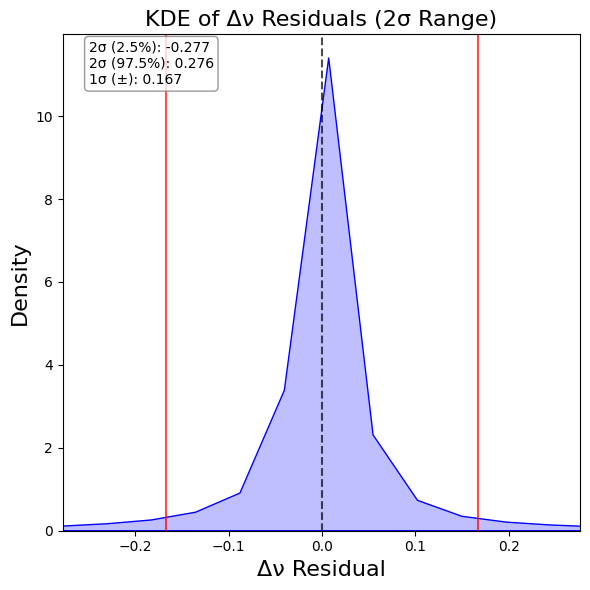

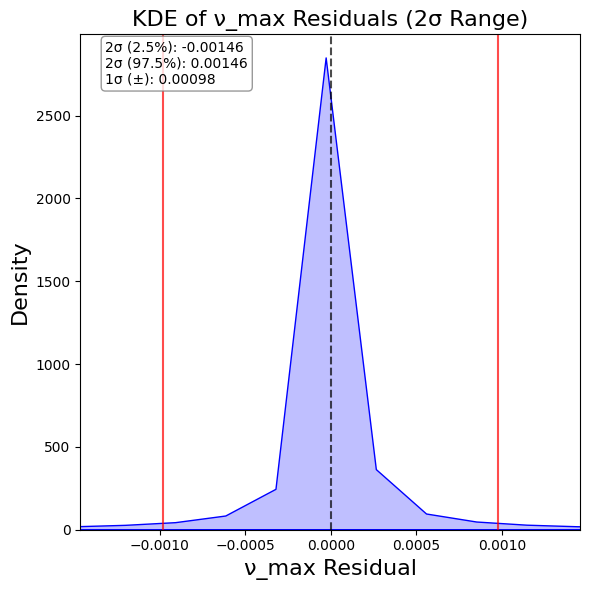

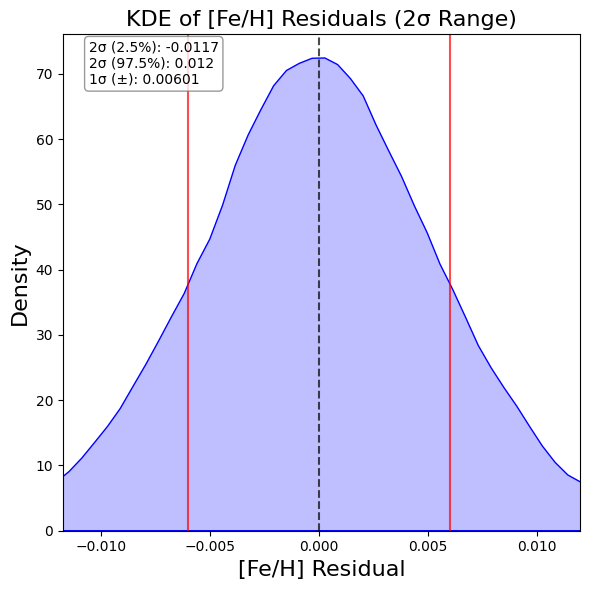

In [6]:
def individual_kde_plots():
    # Define parameter names for each column of normal_residuals
    names = ["Effective Temperature (K)", "Luminosity (Solar Luminosities)", "Δν", "ν_max", "[Fe/H]"]
    
    # Iterate through each parameter
    for i, name in enumerate(names):
        # Extract residuals for current parameter
        residual = normal_residuals[:, i]
        
        # Calculate the standard deviation
        std_dev = np.std(residual)
        
        # Calculate the 2.5th and 97.5th percentiles (2-sigma, 95%)
        lower_bound = np.percentile(residual, 2.5)
        upper_bound = np.percentile(residual, 97.5)
        
        plt.figure(figsize=(6, 6))
        
        # Create KDE plot
        sns.kdeplot(x=residual, fill=True, color='blue')
        
        # Add reference line at zero
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
        
        # Add lines for ±1 standard deviation
        plt.axvline(x=std_dev, color='red', linestyle='-', alpha=0.7)
        plt.axvline(x=-std_dev, color='red', linestyle='-', alpha=0.7)
        
        # Set x-axis limits to show 2-sigma range
        plt.xlim(lower_bound, upper_bound)
        
        # Add title and labels
        plt.title(f'KDE of {name} Residuals (2σ Range)', fontsize=16)
        plt.xlabel(f'{name} Residual', fontsize=16)
        plt.ylabel('Density', fontsize=16)
        
        # Function to format numbers with 3 significant figures
        def format_sig_figs(x, sig_figs=3):
            return f"{x:.{sig_figs}g}"
        
        # Display percentile and standard deviation values in a text box with 3 significant figures
        plt.annotate(f'2σ (2.5%): {format_sig_figs(lower_bound)}\n'
                     f'2σ (97.5%): {format_sig_figs(upper_bound)}\n'
                     f'1σ (±): {format_sig_figs(std_dev)}', 
                    xy=(0.05, 0.9), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.tight_layout()
        plt.show()

individual_kde_plots()

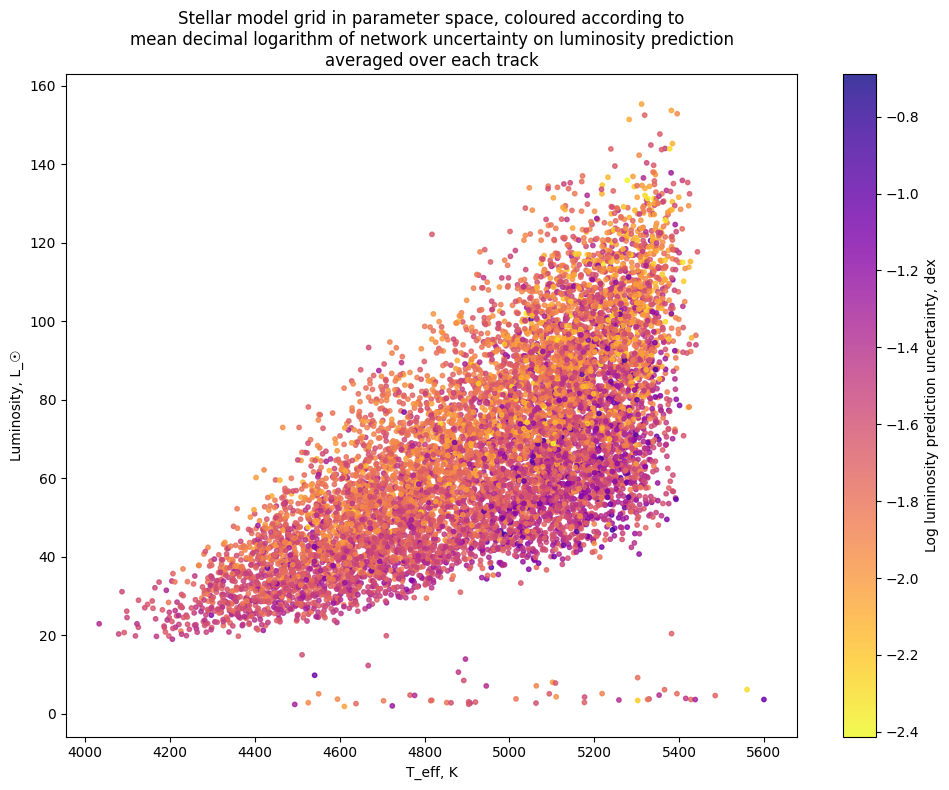

In [ ]:
def plot_model_grid_with_uncertainties():
    # First, ensure that track_indices matches the test set
    # We need track indices only for the test set, not the full dataset
    _, test_indices = train_test_split(range(len(inputs)), test_size=0.2, random_state=1)
    test_track_indices = track_indices[test_indices]
    
    # Extract unique tracks in the test set
    unique_tracks = np.unique(test_track_indices)
    
    # Prepare containers for median values
    median_teff = []
    median_lum = []
    track_residuals = []
    
    # For each track, calculate the median values and mean residual
    for track_idx in unique_tracks:
        # Get indices where test_track_indices equals this track
        mask = test_track_indices == track_idx
        indices = np.where(mask)[0]
        
        if len(indices) == 0:
            continue  # Skip if no points for this track in test set
            
        # Get original values and residuals for this track
        track_teff_original = 10**y_test_original[indices, 0]  # Convert from log10 back to linear scale
        track_lum_original = 10**y_test_original[indices, 1]
        
        # Calculate residuals for this track (for luminosity)
        track_lum_residuals = log_residuals[indices, 1]  # This is residual in log space
        
        # Calculate median values for this track
        median_teff.append(np.median(track_teff_original))
        median_lum.append(np.median(track_lum_original))
        
        # Calculate mean absolute residual for this track
        mean_abs_residual = np.mean(np.abs(track_lum_residuals))
        track_residuals.append(mean_abs_residual)
    
    # Convert to arrays
    median_teff = np.array(median_teff)
    median_lum = np.array(median_lum)
    track_residuals = np.array(track_residuals)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        median_teff, 
        median_lum, 
        c=np.log10(track_residuals + 1e-10),  # Log scale for residuals (add small value to avoid log(0))
        cmap='plasma_r',  
        s=10,  # Marker size
        alpha=0.8
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log luminosity prediction uncertainty, dex')
    
    # Set axis labels and title
    plt.xlabel('T_eff, K')
    plt.ylabel('Luminosity, L_☉')
    plt.title('Stellar model grid in parameter space, coloured according to\n'
              'mean decimal logarithm of network uncertainty on luminosity prediction\n'
              'averaged over each track')
    
    # Use log scale if data spans multiple orders of magnitude
    #if np.max(median_lum)/np.min(median_lum) > 10:
    #   plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_model_grid_with_uncertainties()

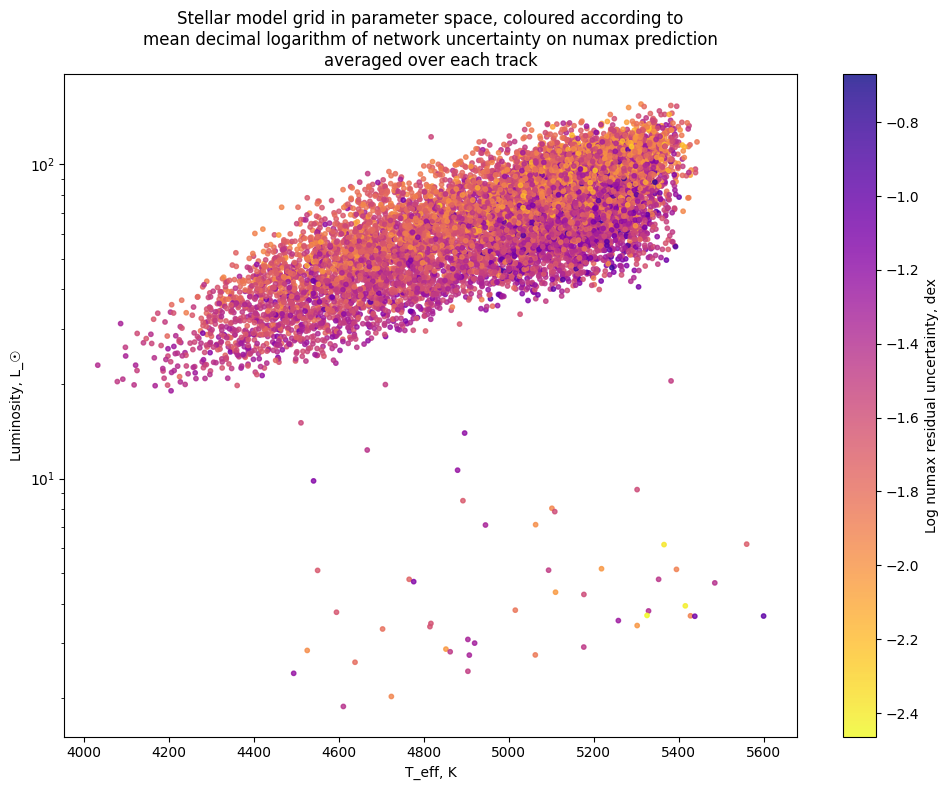

In [ ]:
def plot_model_grid_with_uncertainties_1():

# Same function as above but with colours according to numax residuals

    # First, ensure that track_indices matches the test set
    # We need track indices only for the test set, not the full dataset
    _, test_indices = train_test_split(range(len(inputs)), test_size=0.2, random_state=1)
    test_track_indices = track_indices[test_indices]
    
    # Extract unique tracks in the test set
    unique_tracks = np.unique(test_track_indices)
    
    # Prepare containers for median values and numax residuals
    median_teff = []
    median_lum = []
    track_residuals_numax = []  # Change this to store numax residuals
    
    # For each track, calculate the median values and mean residual for numax
    for track_idx in unique_tracks:
        # Get indices where test_track_indices equals this track
        mask = test_track_indices == track_idx
        indices = np.where(mask)[0]
        
        if len(indices) == 0:
            continue  # Skip if no points for this track in test set
            
        # Get original values and residuals for this track
        track_teff_original = 10**y_test_original[indices, 0]  # Convert from log10 back to linear scale
        track_lum_original = 10**y_test_original[indices, 1]
        track_numax_original = 10**y_test_original[indices, 3]  # Assuming numax is at index 3 in your original output
        
        # Calculate residuals for this track (for numax)
        track_numax_residuals = log_residuals[indices, 3]  # Residuals for numax (in log space)
        
        # Calculate median values for this track
        median_teff.append(np.median(track_teff_original))
        median_lum.append(np.median(track_lum_original))
        
        # Calculate mean absolute residual for numax (at the median point)
        mean_abs_residual_numax = np.mean(np.abs(track_numax_residuals))
        track_residuals_numax.append(mean_abs_residual_numax)
    
    # Convert to arrays
    median_teff = np.array(median_teff)
    median_lum = np.array(median_lum)
    track_residuals_numax = np.array(track_residuals_numax)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        median_teff, 
        median_lum, 
        c=np.log10(track_residuals_numax + 1e-10),  # Log scale for numax residuals (add small value to avoid log(0))
        cmap='plasma_r',
        s=10,  # Marker size
        alpha=0.8
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log numax residual uncertainty, dex')
    
    # Set axis labels and title
    plt.xlabel('T_eff, K')
    plt.ylabel('Luminosity, L_☉')
    plt.title('Stellar model grid in parameter space, coloured according to\n'
              'mean decimal logarithm of network uncertainty on numax prediction\n'
              'averaged over each track')
    
    # Use log scale if data spans multiple orders of magnitude
    if np.max(median_lum)/np.min(median_lum) > 10:
        plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_model_grid_with_uncertainties_1()
